In [1]:
import gymnasium as gym 
import numpy as np
import typing as tp 
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm 

from env import MazeEnv
from qlearner import QLearner

In [2]:
gym.envs.register('Maze-v0', entry_point='env:MazeEnv')

In [3]:
n_episodes = 75_000
learning_rate = 0.01
start_epsilon = 1.0
final_epsilon = 0.15
epsilon_end_eps: int = (n_episodes * 3) // 4 
epsilon_decay = (start_epsilon - final_epsilon) / epsilon_end_eps  # reduce the exploration over time

In [4]:
epsilon_decay, epsilon_end_eps

(1.511111111111111e-05, 56250)

In [5]:
env: MazeEnv = gym.wrappers.RecordEpisodeStatistics(gym.make('Maze-v0'), deque_size=n_episodes)
env

<RecordEpisodeStatistics<OrderEnforcing<PassiveEnvChecker<MazeEnv<Maze-v0>>>>>

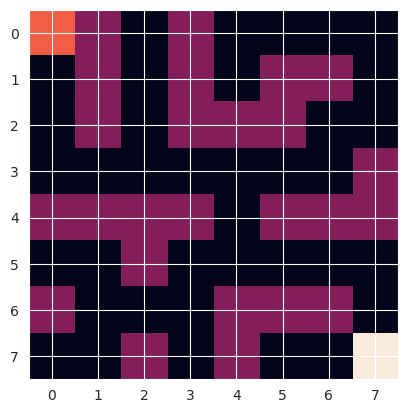

In [6]:
plt.imshow(env.maze)

In [7]:
agent: QLearner = QLearner(env, learning_rate=learning_rate, initial_epsilon=start_epsilon, final_epsilon=final_epsilon, epsilon_decay=epsilon_decay)
agent

In [8]:
from replay_memory import Transition

expert_trajectory: list[Transition] = []

for episode in tqdm.trange(n_episodes):
    obs, info = env.reset()
    done = False

    # play one episode
    while not done:
        action = agent.get_action(env, obs)
        next_obs, reward, terminated, truncated, info = env.step(action)

        expert_trajectory.append(Transition(obs, action, next_obs, reward))

        # update the agent
        agent.update(obs, action, reward, terminated, next_obs)

        # update if the environment is done and the current obs
        done = terminated or truncated
        obs = next_obs

    agent.decay_epsilon()

100%|██████████| 75000/75000 [03:44<00:00, 333.99it/s] 


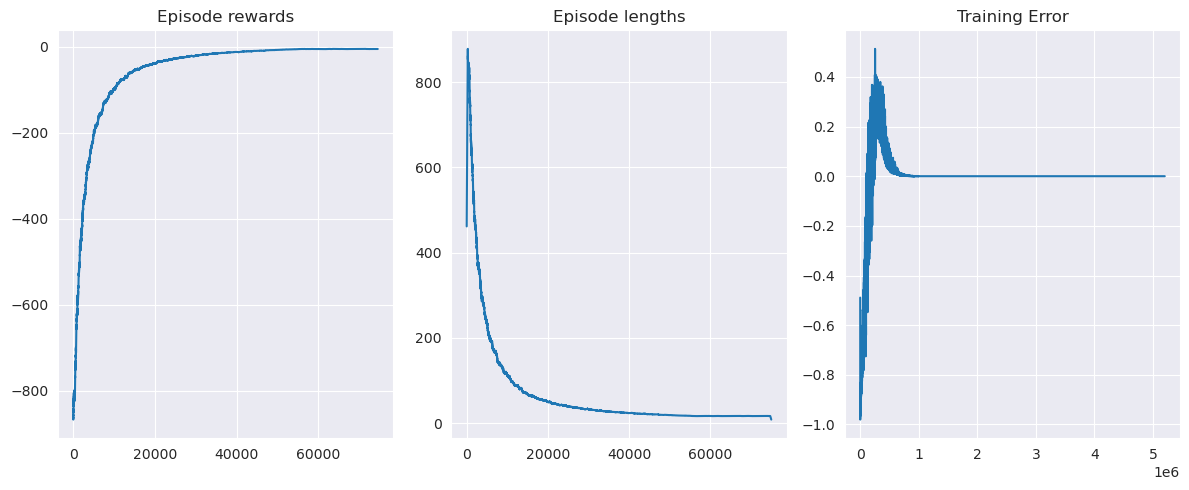

In [9]:
rolling_length = 500
fig, axs = plt.subplots(ncols=3, figsize=(12, 5))
axs[0].set_title("Episode rewards")
# compute and assign a rolling average of the data to provide a smoother graph
reward_moving_average = (
    np.convolve(
        np.array(env.return_queue).flatten(), np.ones(rolling_length), mode="valid"
    )
    / rolling_length
)
axs[0].plot(range(len(reward_moving_average)), reward_moving_average)
axs[1].set_title("Episode lengths")
length_moving_average = (
    np.convolve(
        np.array(env.length_queue).flatten(), np.ones(rolling_length), mode="same"
    )
    / rolling_length
)
axs[1].plot(range(len(length_moving_average)), length_moving_average)
axs[2].set_title("Training Error")
training_error_moving_average = (
    np.convolve(np.array(agent.training_error), np.ones(rolling_length), mode="same")
    / rolling_length
)
axs[2].plot(range(len(training_error_moving_average)), training_error_moving_average)
plt.tight_layout()
plt.show()

In [10]:
obs, info = env.reset()
done = False

coords: list[tuple[int, int]] = [obs]

# play one episode
while not done:
    action = agent.get_action(env, obs)
    next_obs, reward, terminated, truncated, info = env.step(action)
    coords.append(next_obs)

    # update if the environment is done and the current obs
    done = terminated or truncated
    obs = next_obs

xy_pos: np.ndarray = np.array(coords)  # np.array([env.mapping_1d_to_2d(c) for c in coords])
xy_pos.shape

(16, 2)

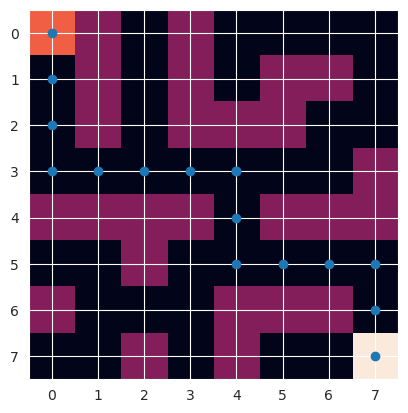

In [11]:
f, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(env.maze)
ax.scatter(xy_pos[:, 1], xy_pos[:, 0])

In [12]:
import torch 
from torch import optim
from torch import nn

import random 
from deep_q_network import DQN
from replay_memory import ReplayMemory, Transition
import math

In [13]:
from torch.nn import functional as F

In [14]:
from collections import namedtuple

LabeledTransition = namedtuple('LabeledTransition', ('x', 'y', 'action', 'reward', 'q_values'))

# for episode in tqdm.trange(NUM_EXPERT_EPISODES, desc='Creating imitation dataset...'):
#     done: bool = False
#     obs, info = env.reset()
#     while not done:
#         action = agent.get_action(env, obs)
#         next_obs, reward, terminated, truncated, info = env.step(action)
# 
#         expert_trajectory.append(Transition(obs, action, next_obs, reward))
# 
#         # update if the environment is done and the current obs
#         done = terminated or truncated
#         obs = next_obs

# Approach taken from ChatGPT: https://chatgpt.com/share/19114277-7947-4817-b776-7bdc2c12e3e6

imitation_q_values: list[torch.Tensor] = [torch.as_tensor(agent.q_values[(x, y)]) for (x, y), _, _, _ in tqdm.tqdm(expert_trajectory, desc='Labeling imitation dataset...')]
imitation_dataset_x: np.ndarray = np.array([(x, y, action, reward) for (x, y), action, _, reward in tqdm.tqdm(expert_trajectory, desc='Massaging imitation X...')]) 

imitation_train_dataset_x: torch.Tensor = torch.FloatTensor(imitation_dataset_x)
imitation_train_dataset_q: torch.Tensor = torch.stack(imitation_q_values).to(dtype=torch.float32)
imitation_train_dataset_x.shape, imitation_train_dataset_q.shape

Massaging imitation X...: 100%|██████████| 5199858/5199858 [00:01<00:00, 3321905.60it/s]


(torch.Size([5199858, 4]), torch.Size([5199858, 4]))

In [15]:
env = gym.wrappers.TimeLimit(env, max_episode_steps=5000)

In [16]:
torch.cuda.synchronize()
force_cpu: bool = False
is_cuda_available: bool = not force_cpu and torch.cuda.is_available()
device = torch.device('cuda' if is_cuda_available else 'cpu')
is_cuda_available, device, torch.__version__

(True, device(type='cuda'), '2.3.1.post300')

In [25]:
# BATCH_SIZE is the number of transitions sampled from the replay buffer
# GAMMA is the discount factor as mentioned in the previous section
# EPS_START is the starting value of epsilon
# EPS_END is the final value of epsilon
# EPS_DECAY controls the rate of exponential decay of epsilon, higher means a slower decay
# TAU is the update rate of the target network
# LR is the learning rate of the ``AdamW`` optimizer

# Deep Q Network code taken from PyTorch - https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html

if torch.cuda.is_available():
    num_episodes = 500
else:
    num_episodes = 250

BATCH_SIZE = 1024
GAMMA = 0.99
EPS_START = 1/3
EPS_END = 0.025
EPS_DECAY = (num_episodes * 3) // 4
TAU = 0.005
LR = 1e-3

# Get number of actions from gym action space
n_actions = env.action_space.n
# Get the number of state observations
state, info = env.reset()
n_observations = len(state)

policy_net = DQN(n_observations, n_actions).to(device)
target_net = DQN(n_observations, n_actions).to(device)
target_net.load_state_dict(policy_net.state_dict())

optimizer = optim.AdamW(policy_net.parameters(), lr=LR, amsgrad=True)
memory = ReplayMemory(10000)


steps_done: int = 0


In [26]:
EPS_DECAY

375

In [27]:
# Begin imitation learning

loss_func = nn.MSELoss()

num_epochs: int = 50  # num_episodes // 2

losses: list[float] = []

for epoch in (prog_bar := tqdm.trange(num_epochs, desc='Performing imitation learning...')):
    c_losses: list[float] = []
    for i in range(0, imitation_train_dataset_x.shape[0], BATCH_SIZE):
        batch_states: torch.Tensor = imitation_train_dataset_x[i: i + BATCH_SIZE, :2].to(device)
        batch_q_values: torch.Tensor = imitation_train_dataset_q[i: i + BATCH_SIZE].to(device)
        
        optimizer.zero_grad()
        action_qs = policy_net(batch_states)
        loss = loss_func(action_qs, batch_q_values)
        loss.backward()
        optimizer.step()
        c_losses.append(loss.detach().cpu().numpy().item())
    losses.append(np.mean(c_losses))
    prog_bar.set_description(f'Performing imitation learning... | Avg Loss: {losses[-1]:0.6f}')
target_net.load_state_dict(policy_net.state_dict())

Performing imitation learning... | Avg Loss: 0.002426: 100%|██████████| 50/50 [06:42<00:00,  8.06s/it]


<All keys matched successfully>

<Axes: xlabel='epoch', ylabel='loss'>

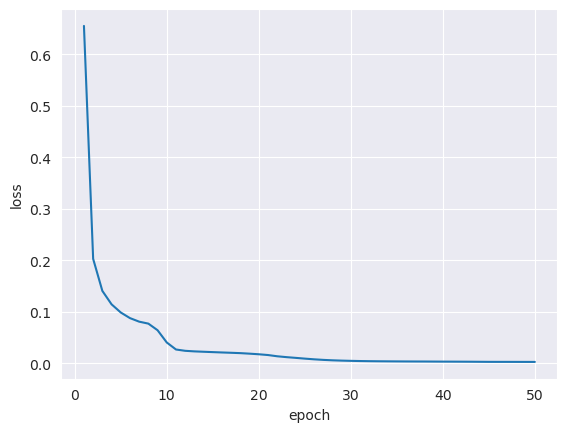

In [28]:
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
imitation_learning_loss_df: pd.DataFrame = pd.DataFrame({'epoch': range(1, num_epochs + 1), 'loss': losses})
sns.lineplot(data=imitation_learning_loss_df, x='epoch', y='loss')

In [38]:
math.exp(-1 * 1 / EPS_DECAY)

0.9973368857305009

In [29]:
def select_action(state):
    global steps_done
    sample = random.random()
    eps_threshold = EPS_END + (EPS_START - EPS_END) * \
        math.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    if sample > eps_threshold:
        with torch.no_grad():
            # t.max(1) will return the largest column value of each row.
            # second column on max result is index of where max element was
            # found, so we pick action with the larger expected reward.
            return policy_net(state).max(1).indices.view(1, 1)
    else:
        return torch.tensor([[env.action_space.sample()]], device=device, dtype=torch.long)


episode_durations = []


def plot_durations(show_result=False):
    plt.figure(1)
    durations_t = torch.tensor(episode_durations, dtype=torch.float)
    if show_result:
        plt.title('Result')
    else:
        plt.clf()
        plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 100 episode averages and plot them too
    if len(durations_t) >= 100:
        means = durations_t.unfold(0, 100, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(99), means))
        plt.plot(means.numpy())

    plt.pause(0.001)  # pause a bit so that plots are updated

In [30]:
def optimize_model():
    if len(memory) < BATCH_SIZE:
        return
    transitions = memory.sample(BATCH_SIZE)
    # Transpose the batch (see https://stackoverflow.com/a/19343/3343043 for
    # detailed explanation). This converts batch-array of Transitions
    # to Transition of batch-arrays.
    batch = Transition(*zip(*transitions))

    # Compute a mask of non-final states and concatenate the batch elements
    # (a final state would've been the one after which simulation ended)
    non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                          batch.next_state)), device=device, dtype=torch.bool)
    non_final_next_states = torch.cat([s for s in batch.next_state
                                                if s is not None])
    state_batch = torch.cat(batch.state)
    action_batch = torch.cat(batch.action)
    reward_batch = torch.cat(batch.reward)

    # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
    # columns of actions taken. These are the actions which would've been taken
    # for each batch state according to policy_net
    state_action_values = policy_net(state_batch).gather(1, action_batch)

    # Compute V(s_{t+1}) for all next states.
    # Expected values of actions for non_final_next_states are computed based
    # on the "older" target_net; selecting their best reward with max(1).values
    # This is merged based on the mask, such that we'll have either the expected
    # state value or 0 in case the state was final.
    next_state_values = torch.zeros(BATCH_SIZE, device=device)
    with torch.no_grad():
        next_state_values[non_final_mask] = target_net(non_final_next_states).max(1).values
    # Compute the expected Q values
    expected_state_action_values = (next_state_values * GAMMA) + reward_batch

    # Compute Huber loss
    criterion = nn.SmoothL1Loss()
    loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

    # Optimize the model
    optimizer.zero_grad()
    loss.backward()
    # In-place gradient clipping
    torch.nn.utils.clip_grad_value_(policy_net.parameters(), 100)
    optimizer.step()

In [31]:
from itertools import count

 15%|█▍        | 74/500 [00:02<00:22, 19.30it/s]

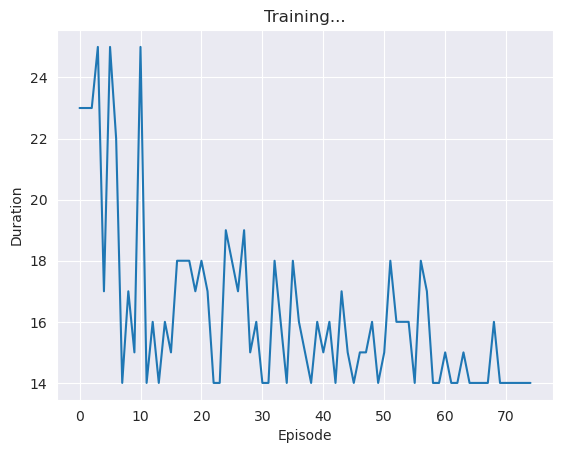

 30%|██▉       | 149/500 [00:09<00:32, 10.82it/s]

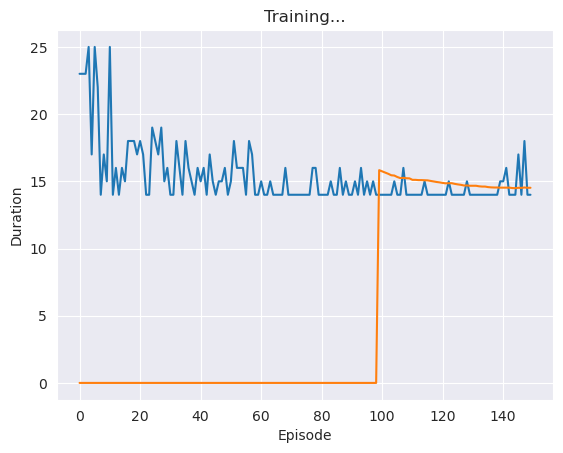

 45%|████▍     | 224/500 [00:16<00:25, 10.93it/s]

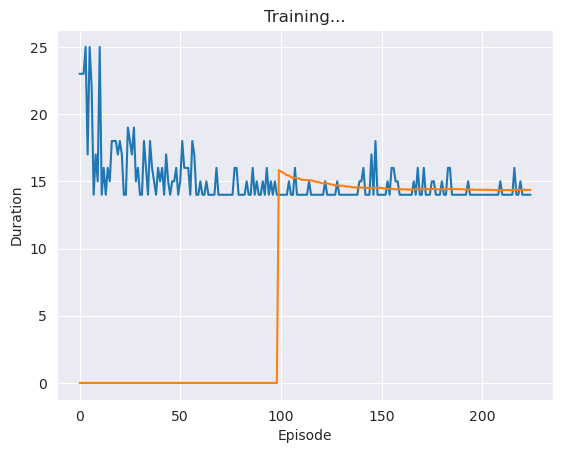

 60%|█████▉    | 298/500 [00:23<00:20, 10.02it/s]

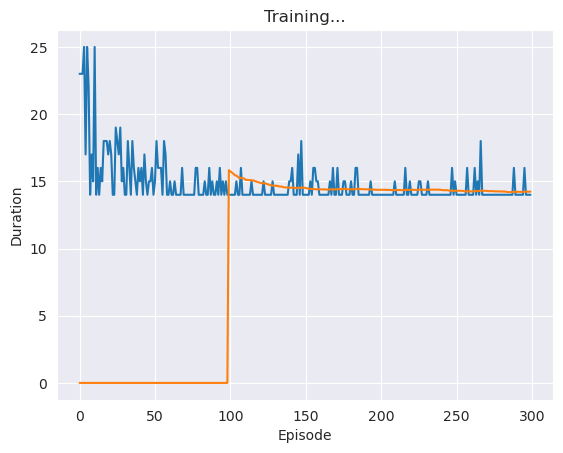

 75%|███████▍  | 373/500 [00:31<00:12,  9.98it/s]

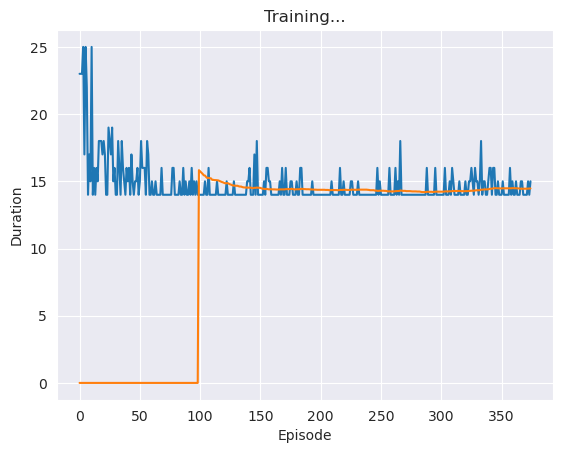

 90%|████████▉ | 449/500 [00:39<00:04, 10.39it/s]

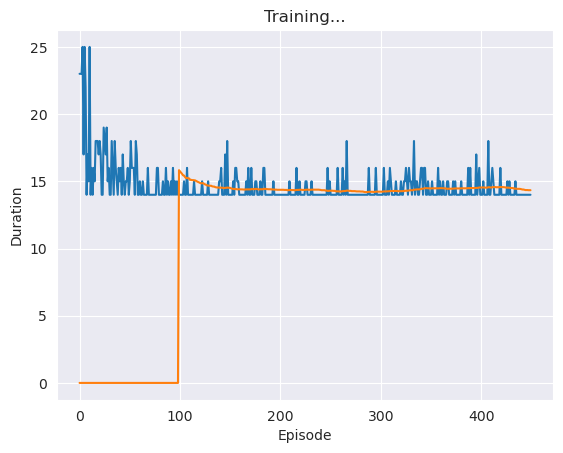

100%|██████████| 500/500 [00:45<00:00, 11.04it/s]


Complete


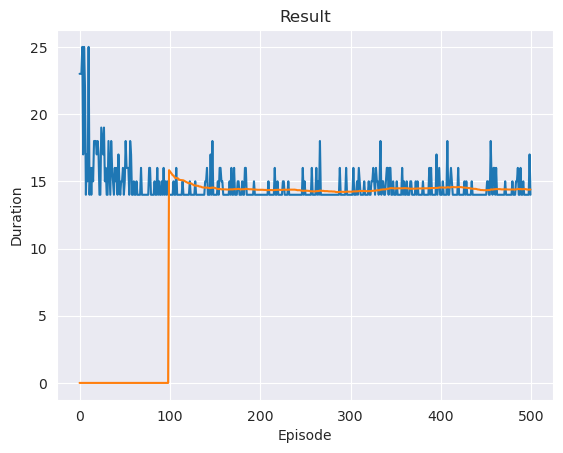

In [32]:
%matplotlib inline
import matplotlib
is_ipython = 'inline' in matplotlib.get_backend()
if is_ipython:
    from IPython import display

plt.ion()

qnetwork_trajectory: list[Transition] = []

for i_episode in tqdm.trange(num_episodes):
    # Initialize the environment and get its state
    state, info = env.reset()
    state = torch.tensor(state, dtype=torch.float32, device=device).unsqueeze(0)
    for t in count():
        action = select_action(state)
        observation, reward, terminated, truncated, _ = env.step(action.item())
        
        qnetwork_trajectory.append((state, action, observation, reward))
        
        reward = torch.tensor([reward], device=device)
        done = terminated or truncated

        if terminated:
            next_state = None
        else:
            next_state = torch.tensor(observation, dtype=torch.float32, device=device).unsqueeze(0)

        # Store the transition in memory
        memory.push(state, action, next_state, reward)

        # Move to the next state
        state = next_state

        # Perform one step of the optimization (on the policy network)
        optimize_model()

        # Soft update of the target network's weights
        # θ′ ← τ θ + (1 −τ )θ′
        target_net_state_dict = target_net.state_dict()
        policy_net_state_dict = policy_net.state_dict()
        for key in policy_net_state_dict:
            target_net_state_dict[key] = policy_net_state_dict[key]*TAU + target_net_state_dict[key]*(1-TAU)
        target_net.load_state_dict(target_net_state_dict)

        if done:
            episode_durations.append(t + 1)
            if len(episode_durations) % 75 == 0:
                plot_durations()
            break

print('Complete')
plot_durations(show_result=True)
plt.ioff()
plt.show()

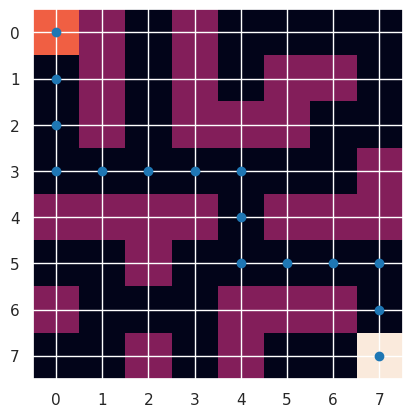

In [33]:
sns.set_context("notebook")

obs, info = env.reset()
done = False

coords: list[tuple[int, int]] = [obs]

# play one episode
while not done:
    action = select_action(torch.Tensor(obs).to(device, dtype=torch.float32).unsqueeze(0))
    next_obs, reward, terminated, truncated, info = env.step(action.item())
    coords.append(next_obs)

    # update if the environment is done and the current obs
    done = terminated or truncated
    obs = next_obs

xy_pos: np.ndarray = np.array(coords)  # np.array([env.mapping_1d_to_2d(c) for c in coords])
f, ax = plt.subplots(nrows=1, ncols=1)
ax.imshow(env.maze)
ax.scatter(xy_pos[:, 1], xy_pos[:, 0])
plt.show()